In [1]:

import os
import re
import csv
import time
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
# four style options:
# white, whitegrid, darkgrid, ticks
sns.set(style='white')
# includes graphs inline with code
%matplotlib inline

# change directory to proper folder
project_path = os.path.dirname(os.path.realpath('__file__'))
os.chdir(project_path)

In [2]:
# load csv data and/or add average walkscore for each neighborhood cluster
dir_list = os.listdir()
if 'Neighborhood_Clusters_W_Walkscore.csv' not in dir_list:
    neighborhood_data = []
    with open('Neighborhood_Clusters.csv',mode='r',encoding='utf-8-sig') as fh:
        csv_obj = csv.reader(fh)
        for row in csv_obj:
            neighborhood_data.append(row)
    row_num = 0
    base_wlkscr_url = 'https://www.walkscore.com/score/'
    for row in neighborhood_data:
        if row_num == 0:
            row.extend(['AV_WLK_SCORE', 'AV_TRNST_SCORE', 'AV_BIKE_SCORE'])
            row_num += 1
            continue
        else:
            city_cluster = row[3].split(',')
            total_wlk_scr = 0
            total_trnst_scr = 0
            total_bike_scr = 0
            num_cities = 0
            for city in city_cluster:
                city = city.strip()
                city_formatted = city.replace(' ', '-')
                wlkscr_page = requests.get(base_wlkscr_url+city_formatted+'-dc', headers={'User-Agent':'Mozilla/5.0'})
                soup = BeautifulSoup(wlkscr_page.text, 'html.parser')
                score_tags = soup.find_all('div', class_='clearfix score-div')
                if len(score_tags) != 3:
                    continue
                wlk_scr_tag = score_tags[0].find('img', src=True, alt=True)
                try:
                    wlk_scr = int(re.findall('/(\d{1,2})\.svg', wlk_scr_tag.get('src'))[0])
                except:
                    wlk_scr = int(re.findall('.*(\d{1,2}).*', wlk_scr_tag.get('alt'))[0])
                total_wlk_scr += wlk_scr
                trnst_scr_tag = score_tags[1].find('img', src=True, alt=True)
                try:
                    trnst_scr = int(re.findall('/(\d{1,2})\.svg', trnst_scr_tag.get('src'))[0])
                except:
                    trnst_scr = int(re.findall('.*(\d{1,2}).*', trnst_scr_tag.get('alt'))[0])
                total_trnst_scr += trnst_scr
                bike_scr_tag = score_tags[2].find('img', src=True, alt=True)
                try:
                    bike_scr = int(re.findall('/(\d{1,2})\.svg', bike_scr_tag.get('src'))[0])
                except:
                    bike_scr = int(re.findall('.*(\d{1,2}).*', bike_scr_tag.get('alt'))[0])
                total_bike_scr += bike_scr
                num_cities += 1
                time.sleep(0.5)
            avg_wlk_scr = total_wlk_scr/num_cities
            avg_trnst_scr = total_trnst_scr/num_cities
            avg_bike_scr = total_bike_scr/num_cities
            row.extend([avg_wlk_scr, avg_trnst_scr, avg_bike_scr])
    with open('Neighborhood_Clusters_W_Walkscore.csv', 'w') as fh:
        writer = csv.writer(fh)
        for row in neighborhood_data:    
            writer.writerow(row)
data = pd.read_csv('Neighborhood_Clusters_W_Walkscore.csv')
data.sample(5)

,OBJECTID,WEB_URL,NAME,NBH_NAMES,TYPE,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,AV_WLK_SCORE,AV_TRNST_SCORE,AV_BIKE_SCORE
23,24,http://planning.dc.gov/,Cluster 3,"Howard University, Le Droit Park, Cardozo/Shaw",Original,{4DD0F1FB-859C-4EAC-BDD0-C712E6DFDCDC},NaN,NaN,NaN,NaN,0,0,64.666667,76.666667,90.333333
43,44,http://planning.dc.gov/,Cluster 37,"Sheridan, Barry Farm, Buena Vista",Original,{F3CB149A-426B-4BC1-8048-0BC712086155},NaN,NaN,NaN,NaN,0,0,51.666667,64.333333,46.333333
26,27,http://planning.dc.gov/,Cluster 6,"Dupont Circle, Connecticut Avenue/K Street",Original,{7D218E74-7585-4393-A0AA-7995C2CD0F2D},NaN,NaN,NaN,NaN,0,0,99.000000,83.000000,98.000000
15,16,http://planning.dc.gov/,Cluster 13,"Spring Valley, Palisades, Wesley Heights, Foxh...",Original,{87DAF271-D2D6-447D-AF4A-0813475306CE},NaN,NaN,NaN,NaN,0,0,51.666667,38.000000,56.833333
34,35,http://planning.dc.gov/,Cluster 5,"West End, Foggy Bottom, GWU",Original,{B064E40A-40A8-49F7-B5FE-D96ED849A117},NaN,NaN,NaN,NaN,0,0,97.666667,87.000000,84.333333


In [3]:
# load shapes into geopandas and sample
shapes = 'Neighborhood_Clusters.shp'
neighborhoods = gpd.read_file(shapes)
neighborhoods.sample(5)

,OBJECTID,WEB_URL,NAME,NBH_NAMES,TYPE,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,SHAPEAREA,SHAPELEN,geometry
41,42,http://planning.dc.gov/,Cluster 34,"Twining, Fairlawn, Randle Highlands, Penn Bran...",Original,{584E4CF2-BD04-47B0-9D3D-2EBDF1B87F9B},None,None,None,None,0,0,"POLYGON ((-76.96265 38.88244, -76.96145 38.882..."
37,38,http://planning.dc.gov/,Cluster 32,"River Terrace, Benning, Greenway, Dupont Park",Original,{CB699FF2-52D9-471F-B48A-89EB5DC0AEBB},None,None,None,None,0,0,"POLYGON ((-76.93760 38.88996, -76.93753 38.889..."
42,43,http://planning.dc.gov/,Cluster 27,"Near Southeast, Navy Yard",Original,{116CB28E-A1A5-44EF-AC79-EE67370ABEC8},None,None,None,None,0,0,"POLYGON ((-76.98726 38.87712, -76.98569 38.877..."
39,40,http://planning.dc.gov/,Cluster 26,"Capitol Hill, Lincoln Park",Original,{346737D3-4784-4E9A-8F22-74F54449478D},None,None,None,None,0,0,"POLYGON ((-76.99496 38.89203, -76.99480 38.892..."
32,33,http://planning.dc.gov/,Cluster 31,"Deanwood, Burrville, Grant Park, Lincoln Heigh...",Original,{84876282-0AFE-4553-8F28-958497FC1A4C},None,None,None,None,0,0,"POLYGON ((-76.91322 38.88976, -76.91940 38.889..."


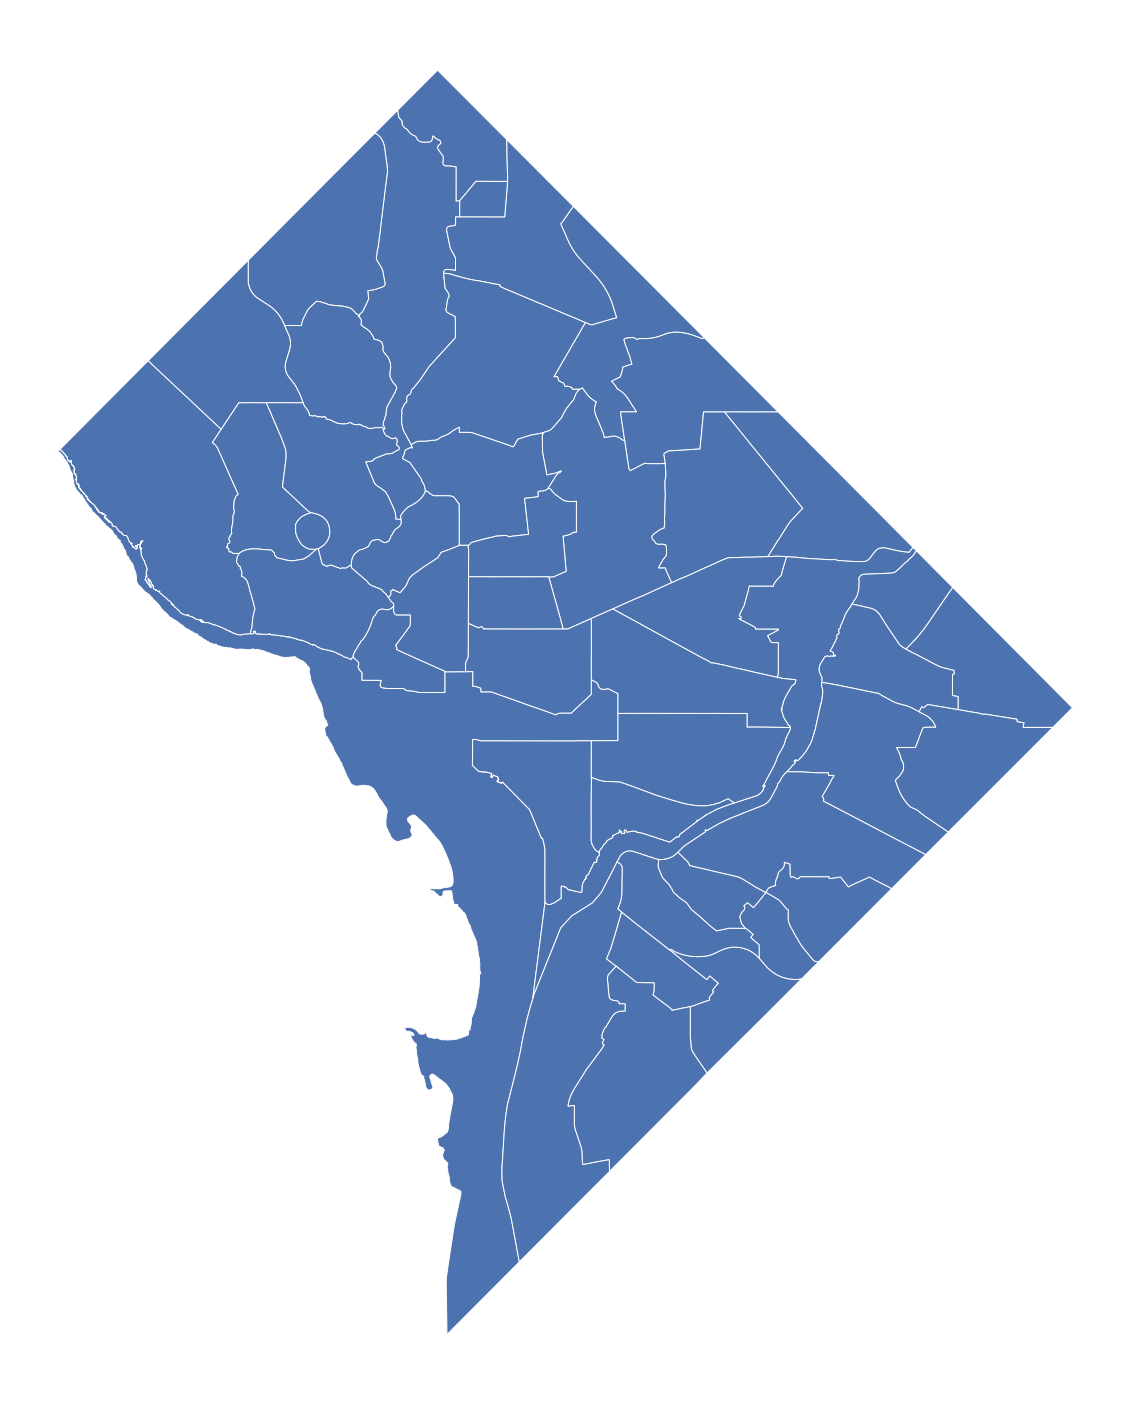

,NAME,NAME,geometry,AV_WLK_SCORE,AV_TRNST_SCORE,AV_BIKE_SCORE
23,Cluster 3,Cluster 3,"POLYGON ((-77.01389 38.92627, -77.01357 38.926...",64.666667,76.666667,90.333333
10,Cluster 36,Cluster 36,"POLYGON ((-76.96877 38.86067, -76.96861 38.860...",38.500000,62.000000,47.000000
32,Cluster 31,Cluster 31,"POLYGON ((-76.91322 38.88976, -76.91940 38.889...",63.200000,66.200000,55.600000
26,Cluster 6,Cluster 6,"POLYGON ((-77.03455 38.91270, -77.03456 38.911...",99.000000,83.000000,98.000000
14,Cluster 20,Cluster 20,"POLYGON ((-76.98629 38.95265, -76.98602 38.952...",63.000000,63.000000,66.000000


In [4]:
# load regions onto plot
neighborhoods.plot(figsize=(20,40))
plt.axis('off')
plt.show()
# merge datasets 
merged = pd.concat([neighborhoods, data], axis=1)
merged[['NAME', 'geometry', 'AV_WLK_SCORE', 'AV_TRNST_SCORE', 'AV_BIKE_SCORE']].sample(5)

<AxesSubplot:title={'center':'Heat Map of Walkscore by Neighbourhood in Washington, DC'}>

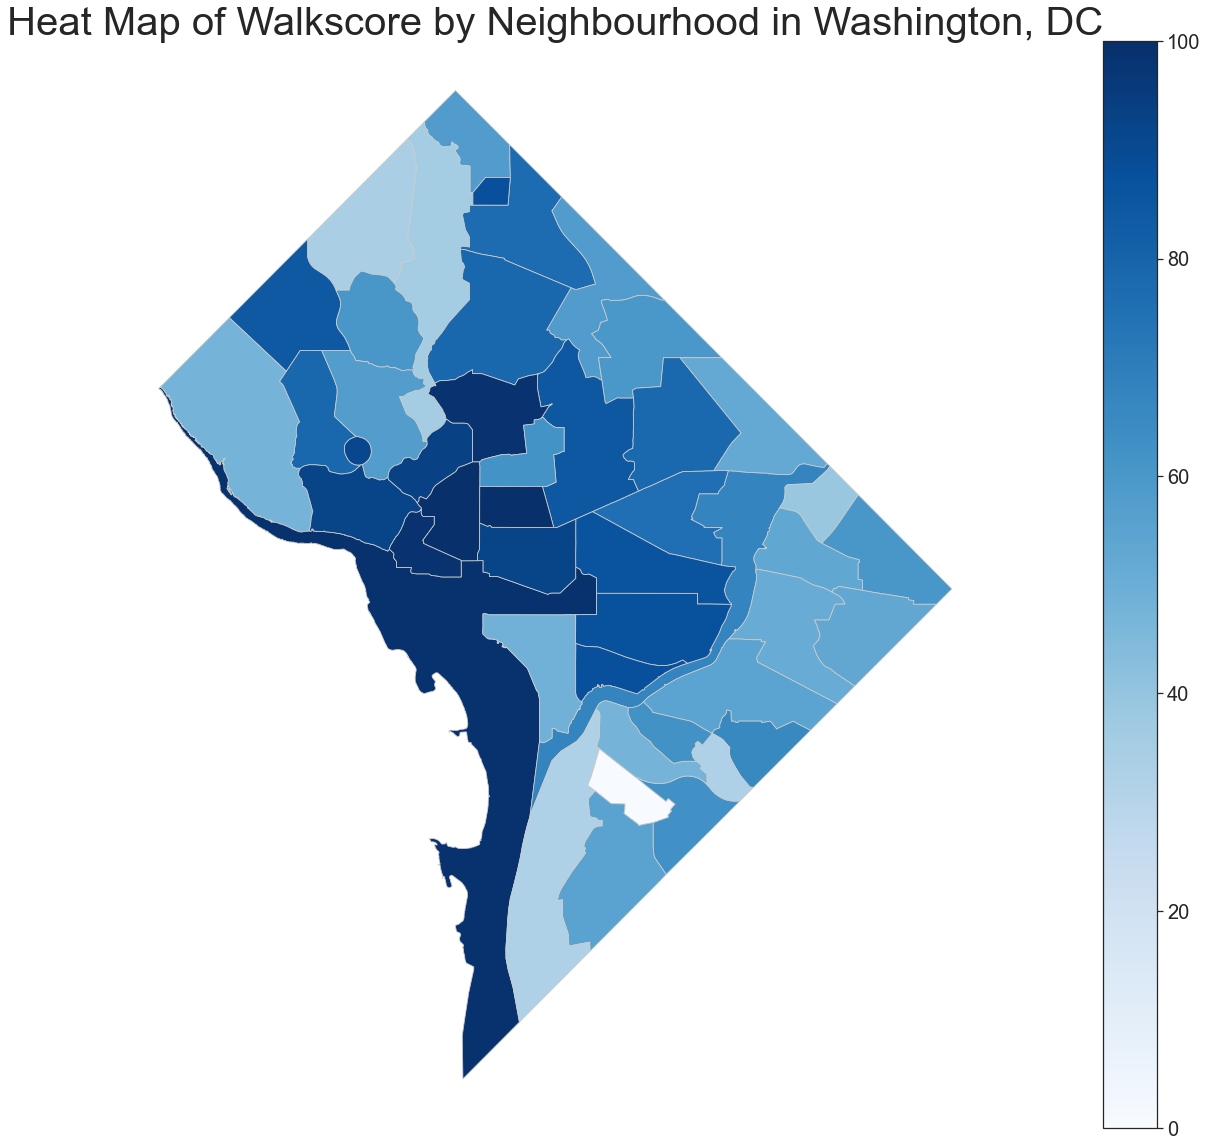

In [5]:
# heatmap by walkscore
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Walkscore by Neighborhood in Washington, DC', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Blues'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('AV_WLK_SCORE', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

<AxesSubplot:title={'center':'Heat Map of Transitscore by Neighbourhood in Washington, DC'}>

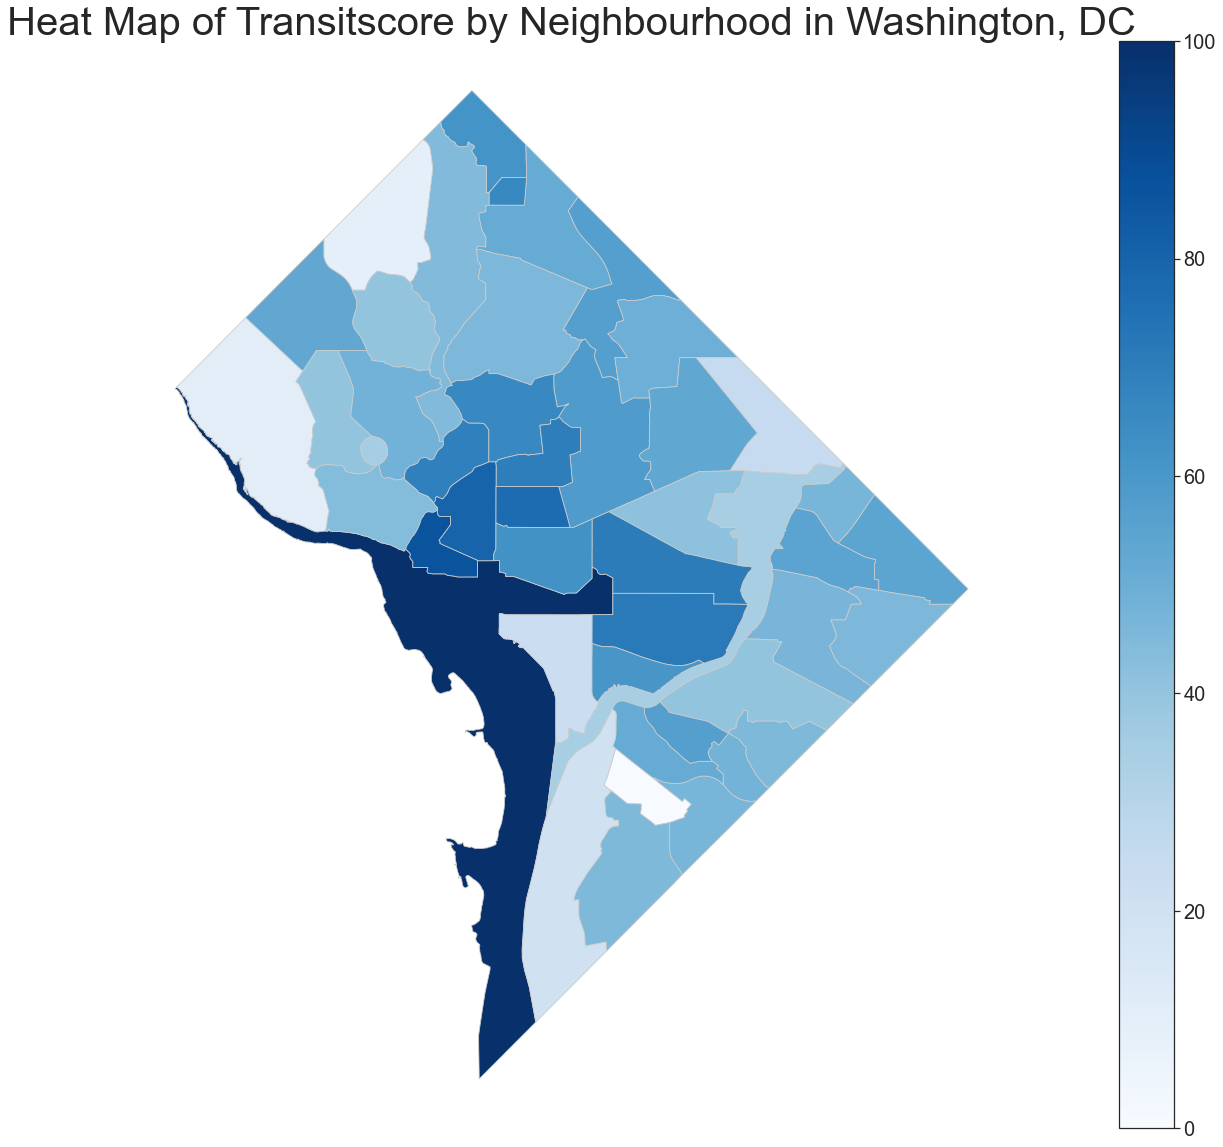

In [6]:
# heatmap by transitscore
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Transitscore by Neighborhood in Washington, DC', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Blues'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('AV_TRNST_SCORE', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))

<AxesSubplot:title={'center':'Heat Map of Bikescore by Neighbourhood in Washington, DC'}>

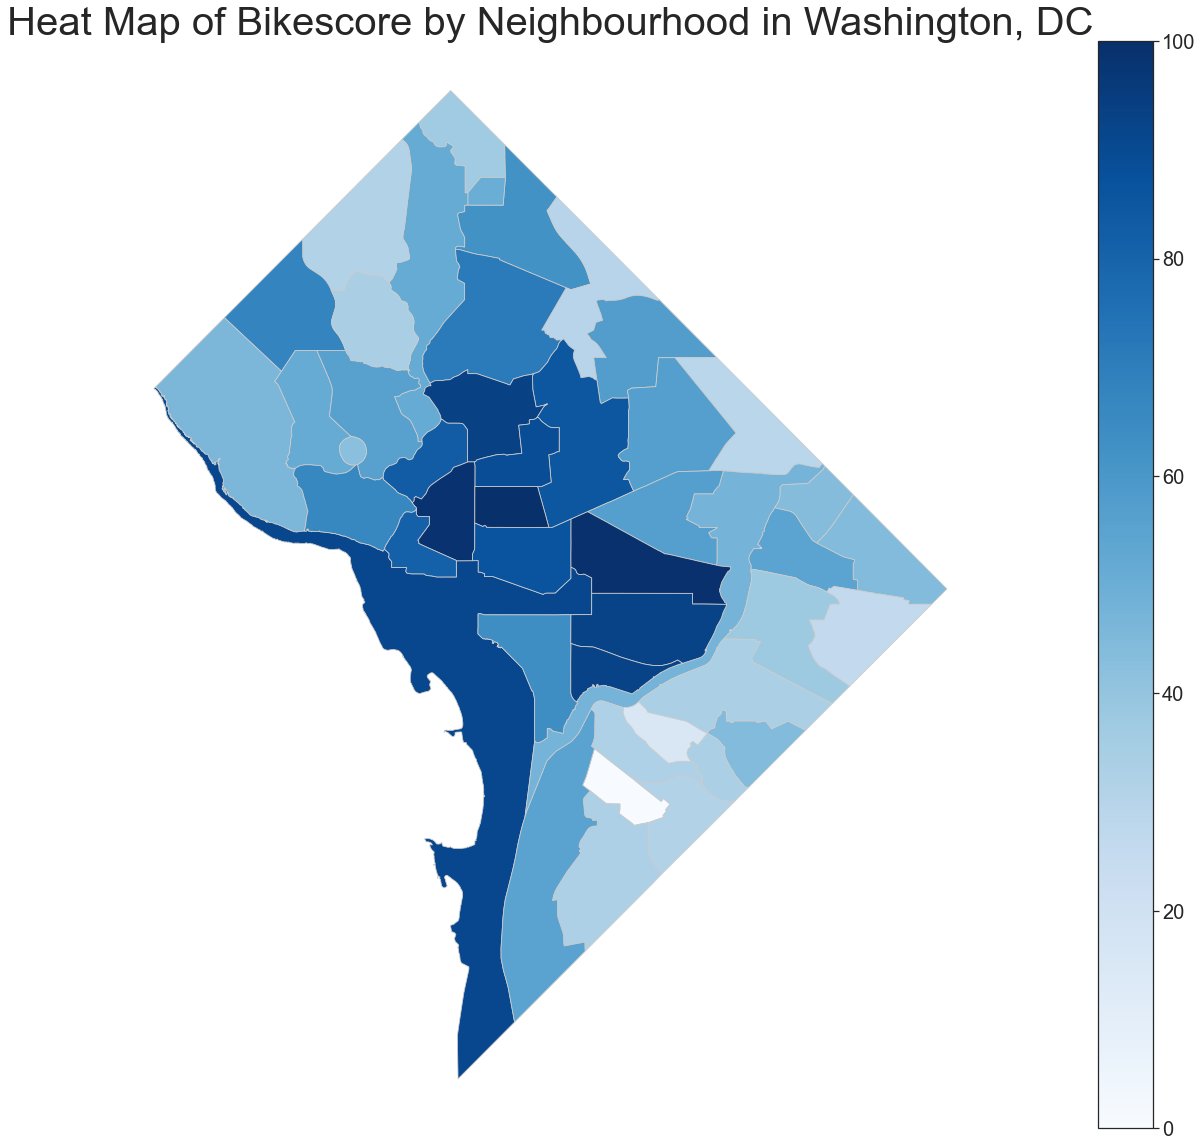

In [7]:
# heatmap by bikescore
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of Bikescore by Neighborhood in Washington, DC', fontdict={'fontsize': '40', 'fontweight' : '3'})
color = 'Blues'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=20)
merged.plot('AV_BIKE_SCORE', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40,20))